# Lipkin Model
#### Kris McBrian
***
Hamiltonian in Quasispin Formalism      
$H = -\epsilon J_z - \frac{1}{2} V(J^2_+ + J_-^2) $

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit as qk

import lipkin_model
import mean_field
import generator_coord

### Functions in each file


 **lipkin_model.py** 
> - diagonalization(N,$\epsilon$,V) - returns eigenvalues of Lipkin Model Hamiltonian
> - exp_val(eig_val, results, n_shots) - returns expectation value based on circuit measurements

**mean_field.py**
>- hamiltonian(N, $\epsilon$, V, $J_z$, $J_+^2 + J_-^2$)   &emsp; - Equation 18 
>- analytic_parity_proj($\theta$,N,$\epsilon$,V,p)     &emsp; &emsp;&ensp;       - Equation 36
>- *Variational Circuit*
>    - Jz_circuit($\theta$, n_shots) - returns $\left\langle J_z \right\rangle$
>    - JpJm_circuit($\theta$, n_shots)- returns $\left\langle J_+^2 + J_-^2 \right\rangle$
>    - Jz_analytic($\theta$) &emsp; &ensp; - Equation 21
>    - JpJm_analytic($\theta$) &ensp; - Equation 23

**generator_coord.py** 
>- numerical(N,$\epsilon$,$\chi$) - $\theta \in [0,\pi]$ - returns eigenvalues of constructed Hamiltonian
>- numerical_parity_proj(N,$\epsilon$,$\chi$) - $\theta \in [-\pi/2,\pi/2]$

<sub><sup>Equation numbers reference Lipkin Notes uploaded on April 15</sup></sub>

In [16]:
# Calculation parameters
n_variation = 40  # resolution for variational method
n_chi = 30        # resolution in chi
n_shots = 2**12   # number of measurements of quantum circuit

# Lipkin Model parameters
N = 10
e = 1
chi = np.linspace(0,2,n_chi)
V = chi*e/float(N-1)

# Variational parameters
theta    = np.linspace(0,np.pi,n_variation)
theta_pari = np.linspace(-np.pi/2, np.pi/2, n_variation) # angles used for good parity

### Diagonalization
****
lipkin_model.py

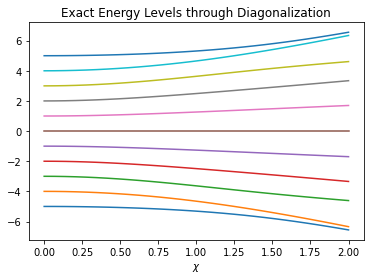

In [17]:
diag_result_list = []

for i_chi in range(n_chi):
    a = lipkin_model.diagonalization(N,e,V[i_chi])
    diag_result_list.append(a)
diag_result = np.array(diag_result_list).reshape(n_chi,-1)
    
plt.figure()
plt.title("Exact Energy Levels through Diagonalization")
plt.plot(chi,diag_result)
plt.xlabel(r"$\chi$")
plt.show()

### Analytic Parity Projection 
***
Equation 36 in notes - mean_field.py

/home/kris/Code/quantum_circuits/qiskit-tutorials/Qractice/McBrian/lipkin_model/mean_field.py:18: RuntimeWarning: invalid value encountered in double_scalars
  return a * (1 + p*np.cos(2*theta)**(N-2))/(1 + p*np.cos(2*theta)**N)


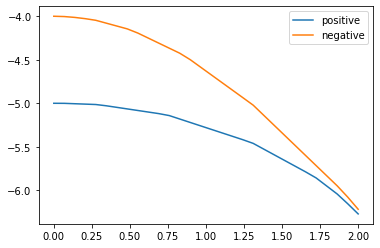

In [18]:
analytic_pos_parity_result = np.zeros(n_chi)
analytic_neg_parity_result = np.zeros(n_chi)
temp_pos_result = np.zeros(n_variation)
temp_neg_result = np.zeros(n_variation)

for i_chi in range(n_chi):
    for i_vari in range(n_variation):
        temp_pos_result[i_vari] = mean_field.analytic_parity_proj(theta[i_vari],N,e,V[i_chi],+1)
        temp_neg_result[i_vari] = mean_field.analytic_parity_proj(theta[i_vari],N,e,V[i_chi],-1)
    analytic_pos_parity_result[i_chi] = np.min(temp_pos_result)
    analytic_neg_parity_result[i_chi] = np.nanmin(temp_neg_result)

    
plt.figure()
plt.plot(chi,analytic_pos_parity_result,label="positive")
plt.plot(chi,analytic_neg_parity_result,label="negative")
plt.legend(loc="best")
plt.show()

### Uniform Approximation Variational Quantum Circuit
***
mean_field.py

In [19]:
theta = np.linspace(0, np.pi, n_variation) 

# for results of simulated circuit 
Jz_results = np.zeros(n_variation)
JpJm_results = np.zeros(n_variation)
circuit_result = np.zeros(n_chi)

# for results of ideal circuit
Jz_exact = np.zeros(n_variation)
JpJm_exact = np.zeros(n_variation)
circuit_exact = np.zeros(n_chi)

backend = qk.Aer.get_backend('qasm_simulator')

for i_chi in range(n_chi):
    for i_vari in range(n_variation):
        Jz_results[i_vari] = mean_field.Jz_circuit(theta[i_vari],n_shots, backend)
        JpJm_results[i_vari] = mean_field.JpJm_circuit(theta[i_vari], n_shots, backend)
        
        Jz_exact[i_vari] = mean_field.Jz_analytic(theta[i_vari])
        JpJm_exact[i_vari] = mean_field.JpJm_analytic(theta[i_vari])
        
    circuit_result[i_chi] = np.min(mean_field.hamiltonian(N,e,V[i_chi],Jz_results,JpJm_results))
    circuit_exact[i_chi]  = np.min(mean_field.hamiltonian(N,e,V[i_chi],Jz_exact  ,JpJm_exact))

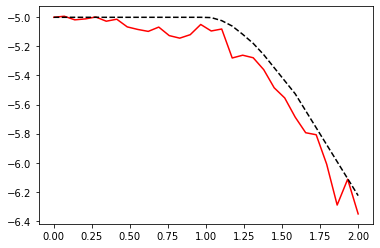

In [20]:
plt.figure()
plt.plot(chi,circuit_result,'r')
plt.plot(chi,circuit_exact, 'k--')
plt.show()

### Uniform Approximation Variational Quantum Circuit using different angles to ensure good parity
***
mean_field.py

In [21]:
'''
    I changed the range of the variational parameter because the minima found was always within this smaller range.
    It does seem to have some effect in smoothing out the final line, but not necessarily decreasing the difference between the lines.  
'''
theta_pari = np.linspace(-np.pi/4, np.pi/4, n_variation)

# for results of simulated circuit 
Jz_pari_results = np.zeros(n_variation)
JpJm_pari_results = np.zeros(n_variation)
circuit_pari_result = np.zeros(n_chi)

# for results of ideal circuit
Jz_pari_exact = np.zeros(n_variation)
JpJm_pari_exact = np.zeros(n_variation)
circuit_pari_exact = np.zeros(n_chi)

backend = qk.Aer.get_backend('qasm_simulator')

for i_chi in range(n_chi):
    for i_vari in range(n_variation):
        Jz_pari_results[i_vari] = mean_field.Jz_circuit(theta_pari[i_vari],n_shots, backend)
        JpJm_pari_results[i_vari] = mean_field.JpJm_circuit(theta_pari[i_vari], n_shots, backend)
        
        Jz_pari_exact[i_vari] = mean_field.Jz_analytic(theta_pari[i_vari])
        JpJm_pari_exact[i_vari] = mean_field.JpJm_analytic(theta_pari[i_vari])
        
    circuit_pari_result[i_chi] = np.min(mean_field.hamiltonian(N,e,V[i_chi],Jz_pari_results,JpJm_pari_results))
    circuit_pari_exact[i_chi]  = np.min(mean_field.hamiltonian(N,e,V[i_chi],Jz_pari_exact  ,JpJm_pari_exact))

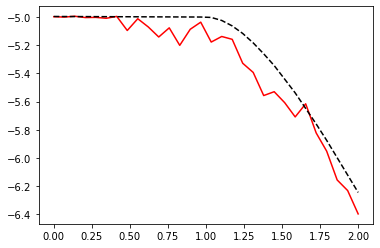

In [22]:
plt.figure()
plt.plot(chi,circuit_pari_result,'r')
plt.plot(chi,circuit_pari_exact, 'k--')
plt.show()

### Generator Coordinate method
***
generator_coord.py

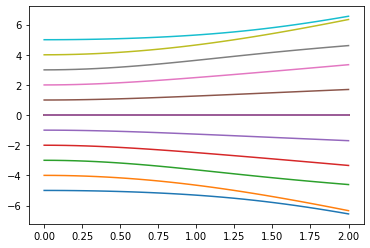

In [23]:
numeric_gen_coord_list = []
for i_chi in range(n_chi):
    numeric_gen_coord_list.append(generator_coord.numerical(N,e,chi[i_chi],theta))
    
numeric_gen_coord = np.array(numeric_gen_coord_list).reshape(n_chi,-1)

plt.figure()
plt.plot(chi,numeric_gen_coord)
plt.show()

### Generator Coordinate method with good Parity
***
generator_coord.py

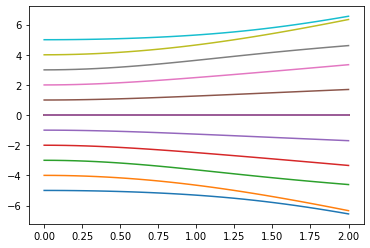

In [24]:
theta_pari = np.linspace(-np.pi/2, np.pi/2, n_variation) 

numeric_gen_parity_list = []
for i_chi in range(n_chi):
    numeric_gen_parity_list.append(generator_coord.numerical(N,e,chi[i_chi], theta_pari))
    
numeric_gen_parity = np.array(numeric_gen_parity_list).reshape(n_chi,-1)

plt.figure()
plt.plot(chi,numeric_gen_parity)
plt.show()

### All Plotted Together

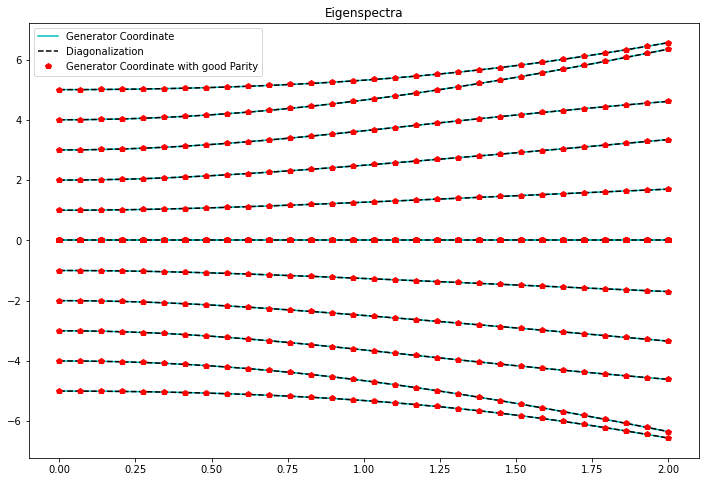

In [25]:
# Eigenspectra 

plt.figure(figsize=(12,8))
plt.plot(chi,numeric_gen_coord[:,0], 'c', label="Generator Coordinate")
plt.plot(chi,numeric_gen_coord[:,1:], 'c')
plt.plot(chi,diag_result[:,0], 'k--', label="Diagonalization")
plt.plot(chi,diag_result[:,1:], 'k--')
plt.plot(chi,numeric_gen_parity[:,0], 'rp', label="Generator Coordinate with good Parity")
plt.plot(chi,numeric_gen_parity[:,1:], 'rp')
plt.legend(loc="best")
plt.title("Eigenspectra")
plt.show()

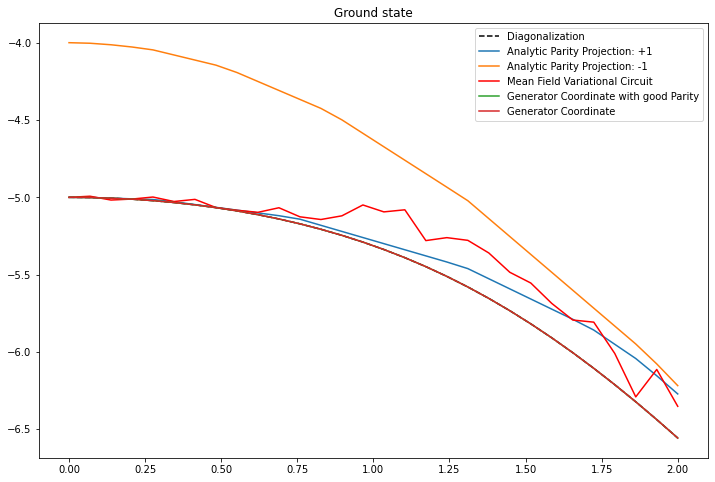

In [26]:
# Ground state

plt.figure(figsize=(12,8))
plt.plot(chi,diag_result[:,0], 'k--', label="Diagonalization")
plt.plot(chi,analytic_pos_parity_result, label="Analytic Parity Projection: +1")
plt.plot(chi,analytic_neg_parity_result, label="Analytic Parity Projection: -1")
plt.plot(chi,circuit_result,'r', label="Mean Field Variational Circuit")
plt.plot(chi,numeric_gen_parity[:,0], label="Generator Coordinate with good Parity")
plt.plot(chi,numeric_gen_coord[:,0], label="Generator Coordinate")
plt.legend(loc="best")
plt.title("Ground state")
plt.show()